#Customer Segmentation
This project aims to get some insight into the customer behaviour of a UK-based company. Assuming a company that selling some of the products online. The manger wants to know how well does the selling performance by segmenting the customers based on their buying behavior on the market. 
we will take the data from UCI Machine Learning called [Online Retail dataset](https://archive.ics.uci.edu/ml/datasets/online+retail).

The steps are:
* Descibing the dataset
* Cleaning & preparing the dataset
* RFM Table
* Handling the skewed data
* Scaling the data
* K-mean model
* Snake plot
* Discussing the results

# Descibing the Dataset
This dataset is a transactional data that contains transactions from December 1st 2010 until December 9th 2011 for a UK-based online retail. Each row represents the transaction that occurs. It includes the product name, quantity, price, and other columns that represents CustomerID. This dataset is relativly big where it includes over half a million (+500K) rows. Therefore, using Spark makes sense to deal with it.

In [ ]:
# This is block to download Spark in orde to use in Colab

# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark
# !pip install pyspark

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# to inite and name the Spark application
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Customer_Segmentation") \
    .getOrCreate()

In [ ]:
# reading survey_results_public_2020 and printing its shape
df = spark.read.csv('Online Retail.csv',inferSchema=True, header=True)
df.count(), len(df.columns)

(541909, 8)

In [ ]:
df.show(2)

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/2010 08:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/2010 08:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
only showing top 2 rows



In [ ]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [ ]:
df.describe().show()

+-------+------------------+------------------+--------------------+-----------------+----------------+-----------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|         Quantity|     InvoiceDate|        UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+-----------------+----------------+-----------------+------------------+-----------+
|  count|            541909|            541909|              540455|           541909|          541909|           541909|            406829|     541909|
|   mean|  559965.752026781|27623.240210938104|             20713.0| 9.55224954743324|            null|4.611113626082965|15287.690570239585|       null|
| stddev|13428.417280799484| 16799.73762842768|                 NaN|218.0811578502348|            null|96.75985306117944|1713.6003033215932|       null|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|           -80

In [ ]:
df.groupby('CustomerID').count().orderBy("count", ascending=False).show()

+----------+------+
|CustomerID| count|
+----------+------+
|      null|135080|
|     17841|  7983|
|     14911|  5903|
|     14096|  5128|
|     12748|  4642|
|     14606|  2782|
|     15311|  2491|
|     14646|  2085|
|     13089|  1857|
|     13263|  1677|
|     14298|  1640|
|     15039|  1508|
|     14156|  1420|
|     18118|  1284|
|     14159|  1212|
|     14796|  1165|
|     15005|  1160|
|     16033|  1152|
|     14056|  1128|
|     14769|  1094|
+----------+------+
only showing top 20 rows



#Cleaning & Preparing the Dataset
As we noticed from the previous section, the dataset includes some null values in customerID column so we will filter them.

In [ ]:
cleaned_df = df.filter("CustomerID is not null")
cleaned_df.describe().show()

+-------+------------------+------------------+--------------------+------------------+----------------+-----------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|     InvoiceDate|        UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+------------------+----------------+-----------------+------------------+-----------+
|  count|            406829|            406829|              406829|            406829|          406829|           406829|            406829|     406829|
|   mean| 560617.1266447864|27430.341352504624|                null| 12.06130339774205|            null|3.460471018535547|15287.690570239585|       null|
| stddev|13106.167694739583|16403.570452626172|                null|248.69337001882369|            null|69.31516172321382|1713.6003033215932|       null|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|        

In [ ]:
# Split the InvoiceDate column into date and time so we can keep the date one and cast it into date type 
split_col = split(cleaned_df['InvoiceDate'], ' ')
cleaned_df = cleaned_df.withColumn('Str_Date', split_col.getItem(0))
cleaned_df = cleaned_df.withColumn('Str_Time', split_col.getItem(1))
cleaned_df.show(2)

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+--------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|  Str_Date|Str_Time|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+--------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/2010 08:26|     2.55|     17850|United Kingdom|01/12/2010|   08:26|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/2010 08:26|     3.39|     17850|United Kingdom|01/12/2010|   08:26|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+--------+
only showing top 2 rows



In [ ]:
# convert the date column into date type
cleaned_df = cleaned_df.withColumn("Date", to_date(col("Str_Date"),"dd/MM/yyyy").cast("date"))\
.drop(col("Str_Date")).drop(col("Str_Time"))
cleaned_df.show(2)

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|      Date|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/2010 08:26|     2.55|     17850|United Kingdom|2010-12-01|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/2010 08:26|     3.39|     17850|United Kingdom|2010-12-01|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+
only showing top 2 rows



In [ ]:
# create new column that includes TotalSum values
cleaned_df = cleaned_df.withColumn('TotalSum', cleaned_df['Quantity']*cleaned_df['UnitPrice'])
cleaned_df.show(2)

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+------------------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|      Date|          TotalSum|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/2010 08:26|     2.55|     17850|United Kingdom|2010-12-01|15.299999999999999|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/2010 08:26|     3.39|     17850|United Kingdom|2010-12-01|             20.34|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+------------------+
only showing top 2 rows



In [ ]:
# Create refernce date variable which is a day after the maximum day in the dataset
import datetime
max_date = cleaned_df.agg({"Date": "max"}).collect()[0]
max_date = max_date['max(Date)']
snapshot_date = max_date + datetime.timedelta(days=1)
snapshot_date

datetime.date(2011, 12, 10)

In [ ]:
# create Recency column by subtracting each purches date from the refernce date we created earlier
cleaned_df = cleaned_df.withColumn('Recency', datediff(lit(snapshot_date) , cleaned_df['Date']))
cleaned_df.show(2)

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+------------------+-------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|      Date|          TotalSum|Recency|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+------------------+-------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/2010 08:26|     2.55|     17850|United Kingdom|2010-12-01|15.299999999999999|    374|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/2010 08:26|     3.39|     17850|United Kingdom|2010-12-01|             20.34|    374|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+------------------+-------+
only showing top 2 rows



#RFM Table
RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.

In [ ]:
# Group the dataset by cusomterID so each row represents all customer purchases
customers = cleaned_df.groupby(['CustomerID'])\
.agg(sum('Recency').alias('Recency'),\
     count('InvoiceNo').alias('Frequency'),\
     sum('TotalSum').alias('MonetaryValue'),\
     )
customers.show(2)

+----------+-------+---------+-----------------+
|CustomerID|Recency|Frequency|    MonetaryValue|
+----------+-------+---------+-----------------+
|     17420|   5485|       30|598.8300000000002|
|     16861|   1296|        8|           151.65|
+----------+-------+---------+-----------------+
only showing top 2 rows



In [ ]:
customers.describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|        CustomerID|           Recency|         Frequency|     MonetaryValue|
+-------+------------------+------------------+------------------+------------------+
|  count|              4372|              4372|              4372|              4372|
|   mean|15299.677721866423|14224.467749313815| 93.05329368709972|1898.4597012808788|
| stddev|1722.3907054276908| 33470.59662803414|232.47160774164965| 8219.345141066578|
|    min|             12346|                 3|                 1|          -4287.63|
|    max|             18287|           1044101|              7983|279489.01999999944|
+-------+------------------+------------------+------------------+------------------+



Text(0.5, 1.0, 'MonetaryValue')

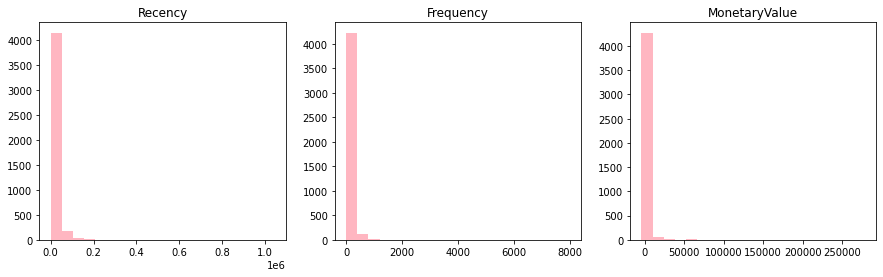

In [ ]:
# Show histogram of the 'Frequency, MonetaryValue, Recency' columns
bins_Fre, counts_Fre = customers.select('Frequency').rdd.flatMap(lambda x: x).histogram(20)
bins_Mon, counts_Mon = customers.select('MonetaryValue').rdd.flatMap(lambda x: x).histogram(20)
bins_Rec, counts_Rec = customers.select('Recency').rdd.flatMap(lambda x: x).histogram(20)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15, 4))
ax1.hist(bins_Rec[:-1], bins=bins_Rec, weights=counts_Rec, color = 'lightpink')
ax1.set_title('Recency')
ax2.hist(bins_Fre[:-1], bins=bins_Fre, weights=counts_Fre, color = 'lightpink')
ax2.set_title('Frequency')
ax3.hist(bins_Mon[:-1], bins=bins_Mon, weights=counts_Mon, color = 'lightpink')
ax3.set_title('MonetaryValue')


#Handling the Skewed Data
There are many ways to handle the skewness of the variables.
* Log Transformation
* Box-Cox Transformation

#Log Transformation

In [ ]:
customers_Trans = customers.withColumn('Recency', F.log1p("Recency"))\
.withColumn('Frequency', F.log1p("Frequency"))\
.withColumn('MonetaryValue', F.log1p("MonetaryValue"))

# clean the results RFM as we found some null values after the transformation
customers_Trans = customers_Trans.filter("MonetaryValue is not null")
customers_Trans.describe().show()

+-------+------------------+------------------+------------------+--------------------+
|summary|        CustomerID|           Recency|         Frequency|       MonetaryValue|
+-------+------------------+------------------+------------------+--------------------+
|  count|              4331|              4331|              4331|                4331|
|   mean|15298.670283999076|  8.51821664762521|3.7651358381787983|    6.55147039918163|
| stddev|1722.3289156173744|1.5843329909623969|1.2447220008581372|  1.2966975897016337|
|    min|             12346|1.3862943611198906|0.6931471805599453|-5.68434188608096...|
|    max|             18287|  13.8586677438017|   8.9851948179913|   12.54072186432083|
+-------+------------------+------------------+------------------+--------------------+



Text(0.5, 1.0, 'MonetaryValue')

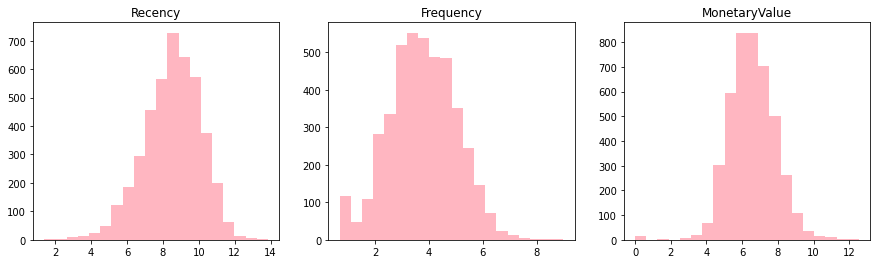

In [ ]:
# Show histogram of the columns using Log Trasformation
bins_Rec, counts_Rec = customers_Trans.select('Recency').rdd.flatMap(lambda x: x).histogram(20)
bins_Fre, counts_Fre = customers_Trans.select('Frequency').rdd.flatMap(lambda x: x).histogram(20)
bins_Mon, counts_Mon = customers_Trans.select('MonetaryValue').rdd.flatMap(lambda x: x).histogram(20)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15, 4))
ax1.hist(bins_Rec[:-1], bins=bins_Rec, weights=counts_Rec, color = 'lightpink')
ax1.set_title('Recency')
ax2.hist(bins_Fre[:-1], bins=bins_Fre, weights=counts_Fre, color = 'lightpink')
ax2.set_title('Frequency')
ax3.hist(bins_Mon[:-1], bins=bins_Mon, weights=counts_Mon, color = 'lightpink')
ax3.set_title('MonetaryValue')


#Box-Cox Transformation with Spark
We can handle the sekwed data using box-cox transformation instead of the Log one. Normally we try all of the methodes and choose the one provide the better results. In this project we will cary on with Log transformation.

In [ ]:
# https://github.com/mahat/SparkMllibTryout/blob/master/Script.py

from pyspark import keyword_only
from pyspark.ml.pipeline import Transformer
#from pyspark.ml.param import Param
from pyspark.sql.dataframe import DataFrame
from pyspark.ml.param.shared import HasOutputCol, HasInputCol, Param
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType,FloatType

from math import log

class BoxCoxTransformer(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, alpha=None):
        super(BoxCoxTransformer, self).__init__()
        self.alpha = Param(self, "alpha", 0)
        self._setDefault(alpha=0)
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None, alpha=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)



    def setAlpha(self, value):
        self._paramMap[self.alpha] = value
        return self

    def getAlpha(self):
        return self.getOrDefault(self.alpha)

    def _transform(self, dataset):
        alpha = self.getAlpha()

        def f(s):
            #print(type(s))
            #print(type(alpha))
            if alpha == 0:
                return log(s)
            elif alpha > 0:
                return (s ** alpha - 1) / alpha

        t = FloatType()
        out_col = self.getOutputCol()
        in_col = dataset[self.getInputCol()]
        return dataset.withColumn(out_col, udf(f, t)(in_col))

In [ ]:
recBoxCox = BoxCoxTransformer(inputCol='Recency', outputCol='RecencyT', alpha=0.54442)
freqBoxCox = BoxCoxTransformer(inputCol='Frequency', outputCol='FrequencyT', alpha=0.54442)
monBoxCox = BoxCoxTransformer(inputCol='MonetaryValue', outputCol='MonetaryValueT', alpha=0.54442)

In [ ]:
recBoxCox.transform(customers).show(2)
# freqBoxCox.transform(customers).show(2)
# monBoxCox.transform(customers).show(2)

+----------+-------+---------+-----------------+---------+
|CustomerID|Recency|Frequency|    MonetaryValue| RecencyT|
+----------+-------+---------+-----------------+---------+
|     17420|   5485|       30|598.8300000000002|197.57388|
|     16861|   1296|        8|           151.65|89.077095|
+----------+-------+---------+-----------------+---------+
only showing top 2 rows



In [ ]:
# create pipline to transfer the columns using Box-Cox
from pyspark.ml import Pipeline
currPipeline = [recBoxCox, freqBoxCox, monBoxCox]
dataPipeline = Pipeline(stages=currPipeline)

convertedData = dataPipeline.fit(customers).transform(customers)
convertedData.show(2)

+----------+-------+---------+-----------------+---------+----------+--------------+
|CustomerID|Recency|Frequency|    MonetaryValue| RecencyT|FrequencyT|MonetaryValueT|
+----------+-------+---------+-----------------+---------+----------+--------------+
|     17420|   5485|       30|598.8300000000002|197.57388|  9.864649|      57.87847|
|     16861|   1296|        8|           151.65|89.077095| 3.8612318|      26.43542|
+----------+-------+---------+-----------------+---------+----------+--------------+
only showing top 2 rows



In [ ]:
convertedData.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|summary|        CustomerID|           Recency|         Frequency|     MonetaryValue|          RecencyT|        FrequencyT|   MonetaryValueT|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|  count|              4372|              4372|              4372|              4372|              4372|              4372|             4329|
|   mean|15299.677721866423|14224.467749313815| 93.05329368709972|1898.4597012808788|261.06175635112936| 15.76293147703648|82.81060199656038|
| stddev|1722.3907054276908| 33470.59662803414|232.47160774164965| 8219.345141066578|231.94386300955674|14.190059556820842|85.53289554820485|
|    min|             12346|                 3|                 1|          -4287.63|         1.5037506|               0.0|       -1.8368171|
|    m

In [ ]:
# clean the results RFM as we found some null values after the transformation
customers_Trans = convertedData.filter("MonetaryValueT is not null")
customers_Trans.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|summary|        CustomerID|           Recency|         Frequency|     MonetaryValue|          RecencyT|        FrequencyT|   MonetaryValueT|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|  count|              4329|              4329|              4329|              4329|              4329|              4329|             4329|
|   mean|15298.686763686763|14350.534072534072| 93.91707091707092|1920.3730547470552|262.85241719557854|15.897462433853335|82.81060199656038|
| stddev|  1721.66804576509|33611.701223144904|233.45949691089453| 8256.804337753134|232.31167946046688|  14.1923994291471|85.53289554820485|
|    min|             12346|                 3|                 1|               0.0|         1.5037506|               0.0|       -1.8368171|
|    m

In [ ]:
# Keep the transformed columns in the RFM table
customers_Trans = customers_Trans.drop('Recency').drop('Frequency').drop('MonetaryValue')
customers_Trans.show(2)

+----------+---------+----------+--------------+
|CustomerID| RecencyT|FrequencyT|MonetaryValueT|
+----------+---------+----------+--------------+
|     17420|197.57388|  9.864649|      57.87847|
|     16861|89.077095| 3.8612318|      26.43542|
+----------+---------+----------+--------------+
only showing top 2 rows



In [ ]:
customers_Trans = customers_Trans.withColumnRenamed('RecencyT','Recency')\
.withColumnRenamed('FrequencyT', 'Frequency')\
.withColumnRenamed('MonetaryValueT','MonetaryValue')
customers_Trans.show(2)

+----------+---------+---------+-------------+
|CustomerID|  Recency|Frequency|MonetaryValue|
+----------+---------+---------+-------------+
|     17420|197.57388| 9.864649|     57.87847|
|     16861|89.077095|3.8612318|     26.43542|
+----------+---------+---------+-------------+
only showing top 2 rows



#Scaling the Data
We aim to have data with the same mean and std so we scale our columns so we can feed them into the kmeans model.

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import MinMaxScaler

va = VectorAssembler(inputCols=["Recency", "Frequency", "MonetaryValue"], outputCol="temp_features")

tmpdf = va.transform(customers_Trans)
sScaler = StandardScaler(
    withMean=True, withStd=True, inputCol="temp_features", outputCol="Scaled_features"
)

# uncomment to try MinMaxScaler instead of the StandardScaler
# sScaler = MinMaxScaler(
#      inputCol="temp_features", outputCol="Scaled_features"
# )

customers_normalized = sScaler.fit(tmpdf).transform(tmpdf)
customers_normalized.show(2)

+----------+-----------------+------------------+-----------------+--------------------+--------------------+
|CustomerID|          Recency|         Frequency|    MonetaryValue|       temp_features|     Scaled_features|
+----------+-----------------+------------------+-----------------+--------------------+--------------------+
|     17420| 8.60995467149755|3.4339872044851463|6.396646281736341|[8.60995467149755...|[0.05790324660008...|
|     16861|7.167809184316444|2.1972245773362196|5.028147719180887|[7.16780918431644...|[-0.8523507816929...|
+----------+-----------------+------------------+-----------------+--------------------+--------------------+
only showing top 2 rows



In [ ]:
customers_normalized.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Recency: double (nullable = true)
 |-- Frequency: double (nullable = true)
 |-- MonetaryValue: double (nullable = true)
 |-- temp_features: vector (nullable = true)
 |-- Scaled_features: vector (nullable = true)



# K-means Model

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
# From the previous stages we get customers_normalized as output and from here on
# we will use RFM 

RFM = customers_normalized

In [ ]:
RFM = RFM.withColumnRenamed("Scaled_features","standardized")
RFM.show(2)

+----------+-----------------+------------------+-----------------+--------------------+--------------------+
|CustomerID|          Recency|         Frequency|    MonetaryValue|       temp_features|        standardized|
+----------+-----------------+------------------+-----------------+--------------------+--------------------+
|     17420| 8.60995467149755|3.4339872044851463|6.396646281736341|[8.60995467149755...|[0.05790324660008...|
|     16861|7.167809184316444|2.1972245773362196|5.028147719180887|[7.16780918431644...|[-0.8523507816929...|
+----------+-----------------+------------------+-----------------+--------------------+--------------------+
only showing top 2 rows



In [ ]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

In [ ]:
# to choose the best k value
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(RFM)
    output=KMeans_fit.transform(RFM)
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.6380943478018933
Silhouette Score: 0.5484840747863858
Silhouette Score: 0.4921088128182708
Silhouette Score: 0.49119103556399046
Silhouette Score: 0.4498185401097182
Silhouette Score: 0.44190211067546237
Silhouette Score: 0.38954572814838634
Silhouette Score: 0.40479062049865433


Text(0, 0.5, 'cost')

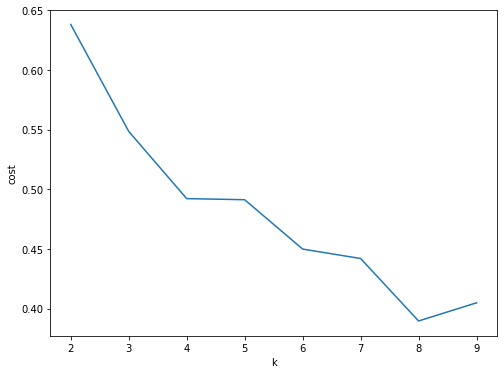

In [ ]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [ ]:
# As there is no right or wring for K, I will use k=3 and you can try to change it
KMeans_algo=KMeans(featuresCol='standardized', k=3)
KMeans_fit=KMeans_algo.fit(RFM)
output=KMeans_fit.transform(RFM)
score=evaluator.evaluate(output)

In [ ]:
output.show()

+----------+------------------+------------------+------------------+--------------------+--------------------+----------+
|CustomerID|           Recency|         Frequency|     MonetaryValue|       temp_features|        standardized|prediction|
+----------+------------------+------------------+------------------+--------------------+--------------------+----------+
|     17420|  8.60995467149755|3.4339872044851463| 6.396646281736341|[8.60995467149755...|[0.05790324660008...|         0|
|     16861| 7.167809184316444|2.1972245773362196| 5.028147719180887|[7.16780918431644...|[-0.8523507816929...|         2|
|     16503| 10.07571668504879| 4.465908118654584|7.2601219556508365|[10.0757166850487...|[0.98306356448304...|         1|
|     15727|11.034244294530804| 5.713732805509369| 8.552552613215992|[11.0342442945308...|[1.58806744621106...|         1|
|     17389| 10.32456350815844|  5.41610040220442|  10.3514078807253|[10.3245635081584...|[1.14013081267465...|         1|
|     15447|7.99

In [ ]:
# Group the customer in each cluster togather
final = output.groupby('prediction').agg(
     mean('Recency').alias('Recency'),\
     mean('Frequency').alias('Frequency'),\
     mean('MonetaryValue').alias('MonetaryValue'))
final.show(3)

+----------+------------------+------------------+-----------------+
|prediction|           Recency|         Frequency|    MonetaryValue|
+----------+------------------+------------------+-----------------+
|         1|10.230585534880072| 5.205071053047823| 7.98443956029841|
|         2| 6.662688679864311|2.3225836658778456|5.267566778660382|
|         0|  8.56591712273978| 3.733095820058637| 6.42666201384779|
+----------+------------------+------------------+-----------------+



#Snake Plot

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, DoubleType

#collecting all the column names as list
dlist = output.columns
def split_array_to_list(col):
    def to_list(v):
        return v.toArray().tolist()
    return F.udf(to_list, ArrayType(DoubleType()))(col)

output = output.select('CustomerID','prediction', split_array_to_list(F.col("standardized")).alias("split_int"))
output.show()

+----------+----------+--------------------+
|CustomerID|prediction|           split_int|
+----------+----------+--------------------+
|     17420|         0|[0.05790324660008...|
|     16861|         2|[-0.8523507816929...|
|     16503|         1|[0.98306356448304...|
|     15727|         1|[1.58806744621106...|
|     17389|         1|[1.14013081267465...|
|     15447|         2|[-0.3272910878481...|
|     14450|         0|[0.40693314197924...|
|     13623|         0|[0.80058924507342...|
|     13285|         1|[1.17205753126381...|
|     16339|         0|[0.08216721494090...|
|     14570|         0|[0.30773616492927...|
|     16386|         0|[-0.2343055104910...|
|     18024|         0|[-0.2502246880709...|
|     12940|         0|[0.14852476735227...|
|     17679|         0|[-0.4511561614574...|
|     16574|         0|[-0.5736484153617...|
|     15957|         0|[-0.8294136163831...|
|     13832|         2|[-2.6186217284019...|
|     15619|         2|[-3.1507619619640...|
|     1579

In [ ]:
#collecting all the column names as list
dlist = output.columns
#Appending new columns to the dataframe
RFM = output.select(dlist+[(col("split_int")[x]).alias("Value"+str(x+1)) for x in range(0, 3)])
RFM.show(2)

+----------+----------+--------------------+--------------------+--------------------+--------------------+
|CustomerID|prediction|           split_int|              Value1|              Value2|              Value3|
+----------+----------+--------------------+--------------------+--------------------+--------------------+
|     17420|         0|[0.05790324660008...|0.057903246600080116|-0.26604224354141137|-0.11939878555717182|
|     16861|         2|[-0.8523507816929...| -0.8523507816929741| -1.2596477444454501|  -1.174770965951478|
+----------+----------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows



In [ ]:
# transfer Spark datafram into pandas dataframe (This is might be not the optimal solution)
RFM_pd = RFM.toPandas()

In [ ]:
import pandas as pd
#  Create the dataframe
df_normalized = pd.DataFrame(RFM_pd, columns=['CustomerID', 'prediction','Value1', 'Value2', 'Value3'])
df_normalized.rename(columns={
    'Value1': 'Recency',
    'Value2': 'Frequency',
    'Value3': 'MonetaryValue'
    }, inplace=True)
df_normalized.head()

,CustomerID,prediction,Recency,Frequency,MonetaryValue
0,17420,0,0.057903,-0.266042,-0.119399
1,16861,2,-0.852351,-1.259648,-1.174771
2,16503,1,0.983064,0.562995,0.546505
3,15727,1,1.588067,1.565488,1.543214
4,17389,1,1.140131,1.326372,2.930473


In [ ]:
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['CustomerID', 'prediction'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,CustomerID,prediction,Attribute,Value
0,17420,0,Recency,0.057903
1,16861,2,Recency,-0.852351
2,16503,1,Recency,0.983064
3,15727,1,Recency,1.588067
4,17389,1,Recency,1.140131


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


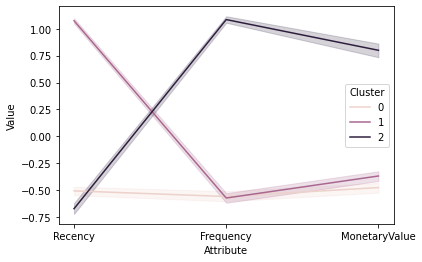

In [ ]:
# Visualize it
sns.lineplot('Attribute', 'Value', hue='prediction', data=df_nor_melt)

#Discussing the Results
We infer that:
 
*  **New Customer**: Cluster 0 is less frequent, less to spend, but they buy the product recently. Therefore, it could be the cluster of new customer.
*   **Churned Customers**: Cluster 1 is less frequent, less to spend, and they buy the product at the old time. Therefore, it could be the cluster of churned customers.
*  **Loyal Customer**: Cluster 2 is frequent, spend more, and they buy the product recently. Therefore, it could be the cluster of a loyal customer.







#Refernces:
* [RFM Model-Based Customer Segmentation](https://link.springer.com/article/10.1057/dbm.2012.17)  
* [Elbow Method](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)
*   [Handling Skewed Data](https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45)
* [Box-Cox Transformation with Spark](https://github.com/mahat/SparkMllibTryout)

